# Digikala Products color classification
In this notebook we are given over 6240 images of Digikala products and the task is to find a model that can detect the color of each object best.

There are 12 classes for these corresponding colors:
- black
- blue
- brown
- green
- grey
- orange
- pink
- purple
- red
- silver
- white
- yellow

These are what we will cover in this notebook:

-  **Extract hsv histogram, use it as features and train `sklearn` classifiers.**
-  **Use `tf.data` as data generator and practice some of usefule methods.**
-  **Use `Tensorboard` to track metrics like accuracy, precision, loss, auc-roc curve and etc.**
- **Save confusion matrix plot and GradCam output (using `tf-explain`) in tensorboard images to get better insights about models.**
-  **How to apply numpy operations on `tf.data` using tf.py_function.**
- **Use `albumentations` for more strong and professional augmentations.**

In [1]:
# Check number of images
!find ../input/digikala-color-classification/train -type f | wc -l

6239


In [2]:
# Check paths (labels)
!ls -a ../input/digikala-color-classification/train

.   black  brown  grey	  pink	  red	  white
..  blue   green  orange  purple  silver  yellow


# Preprocessing Operations

In [3]:
!pip install natsort

In [4]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
from random import choice

# Crop extra white space around the images

the function `crop image` is based on [this stackoverflow answer](https://stackoverflow.com/questions/64046602/how-can-i-crop-an-object-from-surrounding-white-background-in-python-numpy) to my question.

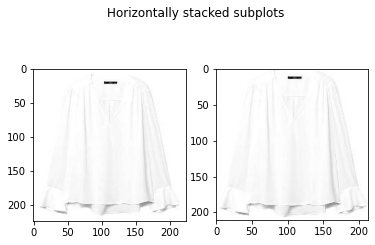

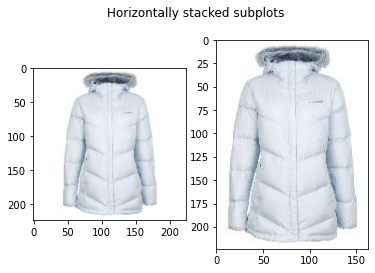

In [5]:
root = '../input/digikala-color-classification/train'

def generate_random_img_label():
    paths = list(Path(root).rglob('*.jp*g'))
    path = choice(paths)
    img = cv2.imread(path.as_posix())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = path.parent.stem
    return img, label

def crop_image(img):
    """
    This is a function that crops extra white background
    around product.
    Src:
        https://stackoverflow.com/questions/64046602/how-can-i-crop-an-object-from-surrounding-white-background-in-python-numpy
    """
    mask = img!=255
    mask = mask.any(2)
    mask0,mask1 = mask.any(0),mask.any(1)
    colstart, colend = mask0.argmax(), len(mask0)-mask0[::-1].argmax()+1
    rowstart, rowend = mask1.argmax(), len(mask1)-mask1[::-1].argmax()+1
    return img[rowstart:rowend, colstart:colend]


images = list(Path(root).rglob('*.jp*g'))

for i in range(2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Horizontally stacked subplots')
    rnd = choice(images)
    # Open image and make into Numpy array
    img = cv2.imread(rnd.as_posix())
    ax1.imshow(img)

    img = crop_image(img)
    ax2.imshow(img)
    plt.show()

**Successfully `crop_image` can crop the extra white space around the product.**

# Method 1: Extract hsv histogram (hue channel provides color variety).

[HSV format description](`https://en.wikipedia.org/wiki/HSL_and_HSV`)

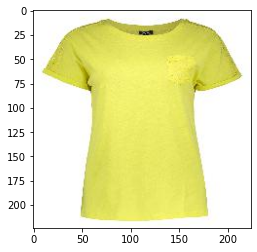

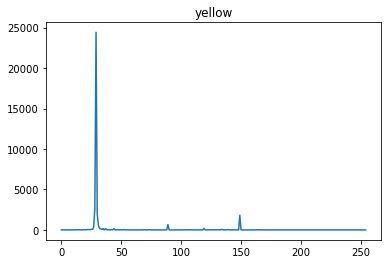

In [6]:
def hsv_histogram(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[..., 0]
    return np.bincount(h.ravel(), minlength=256)

img, label = generate_random_img_label()
img = crop_image(img)
plt.imshow(img)
plt.show()

hist = hsv_histogram(img)
plt.plot(hist[1:])
plt.title(label)
plt.show()

# Let's check out classifiers accuracy on hsv format `h channel` histogram

In [7]:
# Let's bring the color labels
from os import listdir
from natsort import natsorted

paths  = listdir('../input/digikala-color-classification/train')
labels = {path: i for i, path in enumerate(natsorted(paths))}
labels

{'black': 0,
 'blue': 1,
 'brown': 2,
 'green': 3,
 'grey': 4,
 'orange': 5,
 'pink': 6,
 'purple': 7,
 'red': 8,
 'silver': 9,
 'white': 10,
 'yellow': 11}

In [8]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

# find all images
root = '../input/digikala-color-classification/train'
paths = natsorted(list(Path(root).rglob('*.jp*g')), key=lambda x: x.parent.stem)

# dataframe for saving features
df = pd.DataFrame(columns=[i for i in range(255)])
col_labels = []

# loop over all items and calculate the images histogram.
for i, path in enumerate(paths):
    img = cv2.imread(path.as_posix())
    label = labels[path.parent.stem]
    img = crop_image(img)
    hist = hsv_histogram(img)
    df = df.append(pd.DataFrame(hist[1:]).T, ignore_index=True)
    col_labels.append(label) # append labels to insert after the loop
    
df['labels'] = col_labels # Insert the labels

In [9]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,labels
0,0,0,0,0,27,2,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,9,14,25,0,7,8,24,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,170,404,0,0,0,3959,...,0,0,0,0,0,0,0,0,0,0
4,1,6,0,9,17,92,0,11,13,137,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_copy = df.copy()
Y = df_copy.pop('labels')
X = df_copy.copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1989)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [11]:
classifiers = [
    RandomForestClassifier,
    BaggingClassifier,
    DecisionTreeClassifier,
    SVC,
    KNeighborsClassifier,
    RidgeClassifier
]

params = {
    RandomForestClassifier.__name__: dict(n_estimators=150, 
                                          max_depth=5, 
                                          min_samples_split=5,
                                          n_jobs=-2),
    BaggingClassifier.__name__: {},
    SVC.__name__: {},
    RidgeClassifier.__name__: {},
    DecisionTreeClassifier.__name__: {},
    KNeighborsClassifier.__name__: dict(metric='manhattan', 
                                        n_neighbors=len(labels))
}

In [12]:
for classifier in classifiers:
    Classifier = classifier(**params[classifier.__name__])
    Classifier.fit(X_train, y_train)
    y_pred = Classifier.predict(X_test)
    print(classifier.__name__)
    print('*' * 20)
    print(classification_report(y_test, y_pred, target_names=list(labels.keys())))

RandomForestClassifier
********************
              precision    recall  f1-score   support

       black       0.00      0.00      0.00        72
        blue       0.73      0.92      0.82       129
       brown       0.38      0.80      0.51       113
       green       0.74      0.63      0.68       159
        grey       0.27      0.40      0.32       149
      orange       0.80      0.46      0.58        70
        pink       0.50      0.03      0.05        69
      purple       0.82      0.61      0.70        67
         red       0.65      0.91      0.76       122
      silver       0.00      0.00      0.00        73
       white       0.40      0.36      0.38       143
      yellow       0.73      0.90      0.81        82

    accuracy                           0.54      1248
   macro avg       0.50      0.50      0.47      1248
weighted avg       0.51      0.54      0.50      1248

BaggingClassifier
********************
              precision    recall  f1-score   supp

# Method 2: Use Deep learning models to extract features and classify the items according to colors

In [13]:
!pip install natsort
!pip install tf-explain
!pip install -U tensorboard-plugin-profile

from os.path import isdir, dirname, abspath, join, sep
from random import shuffle, choice, uniform
from sklearn.metrics import confusion_matrix
from os import makedirs, listdir
import matplotlib.pyplot as plt
from datetime import datetime
from natsort import natsorted
from pathlib import Path
import matplotlib as mpl
from io import BytesIO
import seaborn as sns
from tqdm import tqdm
import numpy as np
import itertools
import cv2
import os

from tensorflow.keras.applications import (DenseNet201, InceptionV3, MobileNetV2,
                                           ResNet101, Xception, EfficientNetB7,
                                           VGG19, NASNetLarge)
from tensorflow.keras.applications import (densenet, inception_v3, mobilenet_v2, 
                                           resnet, xception, efficientnet, 
                                           vgg19, nasnet)
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, EarlyStopping, 
                                        LearningRateScheduler)

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential,Model
from tensorflow.keras import backend as K
import tf_explain as tfe
import tensorflow as tf
import sklearn

plt.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


     |████████████████████████████████| 43 kB 492 kB/s 
     |████████████████████████████████| 1.2 MB 2.9 MB/s 


In [14]:
class Params:
    root = 'drive/MyDrive'
    data_path = '../input/digikala-color-classification/train'
    path_to_save = join(root, './logs')
    autotune = tf.data.experimental.AUTOTUNE
    batch_size = 16
    epochs = 50
    lr = 1e-2
    decay = 1e-6
    momentum = 0.95
    nesterov = True
    block_to_gradcam = "block14_sepconv2_act"
    model = 'xception'
    
if not isdir(Params.root):
    makedirs(Params.root)

if not isdir(Params.path_to_save):
    makedirs(Params.path_to_save)


In [15]:
sorted_paths = natsorted(listdir(Params.data_path))

labels = {v:k for k, v in enumerate(sorted_paths)}
rev_labels = {v:k for k,v in labels.items()}
class_names = list(labels.keys())

# print(labels)

print("number of images per each label")
for item in sorted_paths:
    label_path = Path(join(Params.data_path, item))
    num_images = list(label_path.rglob('*.jp*g'))
    print(f"'{item}': {len(num_images)}")

number of images per each label
'black': 334
'blue': 651
'brown': 681
'green': 704
'grey': 686
'orange': 318
'pink': 341
'purple': 352
'red': 689
'silver': 350
'white': 706
'yellow': 427


# Initialize deep models and their corresponding preprocessing function in a *dict*

In [16]:
models = {
    'densenet': DenseNet201,
    'xception': Xception,
    'inceptionv3': InceptionV3,
    'effecientnetb7': EfficientNetB7,
    'vgg19': VGG19,
    'nasnetlarge': NASNetLarge,
    'mobilenetv2': MobileNetV2,
    'resnet': ResNet101
}

# To use => myNet = models['densenet']()

preprocess_pipeline = {
    'densenet': densenet.preprocess_input,
    'xception': xception.preprocess_input,
    'inceptionv3': inception_v3.preprocess_input,
    'effecientnetb7': efficientnet.preprocess_input,
    'vgg19': vgg19.preprocess_input,
    'nasnetlarge': nasnet.preprocess_input,
    'mobilenetv2': mobilenet_v2.preprocess_input,
    'resnet': resnet.preprocess_input
}


# Data Generator Utils

the output is a string typed Tensor. What we are going to do is to produce the image and label. image is going to be accessible by using the image address and its corresponding parent directory would be its label.

Note that `tf.data.Dataset` is going to be run in graph mode and we wouldn't be able to use the simple functions on tensor input. after a little bit of research, I found [this stackoverflow link](https://stackoverflow.com/questions/62079198/how-to-apply-map-function-to-the-tf-tensor) which suggests `tf.py_function` to overcome this issue.

# Various augmentation techniques using *Albumentation*

- Flip
- Transpose
- Rotate
- Blur (Median - Motion - Glasss)
- Brightness 
- Noise (Gaussian - Additive - Multiplicative)
- Distortion (Optical - Grid)
- Nature inspired (Fog - Rain - Shadow)


Tutorial: https://albumentations.ai/docs/getting_started/image_augmentation/



In [17]:
import albumentations as A
from albumentations import OneOf, Compose

In [18]:
def aug_flip(p=0.5):
    return OneOf([
        A.Flip(),
        A.Transpose(),
        A.RandomRotate90(),
        A.ShiftScaleRotate()
    ],
        p=p)

def aug_blur(p=0.5):
    return OneOf([
        A.MotionBlur(),
        A.MedianBlur(blur_limit=3),
        A.Blur(blur_limit=3),
        # A.GlassBlur()
        ],
        p=p)

def aug_brightness(p=0.5):
    # To do: Why brightness augmentations turns image to black.
    return OneOf([
#         A.CLAHE(),
        A.HueSaturationValue(),
        A.RandomBrightness(),
        A.RandomContrast(),
        # A.RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2,brightness_by_max=False)
    ], 
        p=p)

def aug_noise(p=0.5):
    return OneOf([
        A.IAAAdditiveGaussianNoise(),
        A.GaussNoise(),
        # A.MultiplicativeNoise()
    ], 
        p=p)

def aug_distortion(p=0.5):
    return OneOf([
        A.OpticalDistortion(),
        A.GridDistortion()
    ], 
        p=p)
        
def aug_iaa(p=0.5):
    return OneOf([
        A.IAAEmboss(),
        A.IAAPerspective(),
        A.IAAFliplr(),
        A.IAAFlipud(),
        A.IAASharpen(),
        A.IAASuperpixels()
    ],
        p=p)

def aug_nature(p=0.5):
    return OneOf([
        A.RandomRain(),
        A.RandomFog(),
        A.RandomShadow(),
        A.RandomSunFlare()
    ],
        p=p)

# def aug_color(p=0.5):
#     OneOf([
#         A.ColorJitter(),
#         A.Solarize(),
#         A.Posterize(),
#     ],
#         p=p)


def strong_aug(image, all_p=0.5, flip_p=0.5, blur_p=0.5, distort_p=.0, iaa_p=.0, brightness_p=.0, noise_p=.0, color_p=0.0):
    aug = Compose([
        aug_flip(p=flip_p), 
        aug_distortion(p=distort_p),
        aug_iaa(p=iaa_p),
        # aug_nature(p=nature_p),
        aug_brightness(p=brightness_p),
        aug_noise(p=noise_p),
        aug_blur(p=blur_p),
        # aug_color(p=color_p)
    ], 
        p=all_p)
    result = aug(image=image)
    return result['image']

In [19]:
AUG_PROBABILITIES = {
    'all_p': 1.0,
    'flip_p': 0.8,
    'blur_p': 0.3,
    'distort_p': 0.0,
    # 'nature_p': 0.0,
    'iaa_p': 0.0, # to use imgaug
    'brightness_p': 0.0,
    'noise_p': 0.0,
    # 'color_p': 0.0
}


def crop_image(img):
    """
    This is a function that crops extra white background
    around product.
    Src:
        https://stackoverflow.com/questions/64046602/how-can-i-crop-an-object-from-surrounding-white-background-in-python-numpy
    """
    mask = img!=255
    mask = mask.any(2)
    mask0,mask1 = mask.any(0),mask.any(1)
    colstart, colend = mask0.argmax(), len(mask0)-mask0[::-1].argmax()+1
    rowstart, rowend = mask1.argmax(), len(mask1)-mask1[::-1].argmax()+1
    return img[rowstart:rowend, colstart:colend]

def process_train(path):
    """
    Load file from path, process and return image and its
    corresponding label. (includes augmentation)
    
    """
    path = path.numpy().decode('utf-8') # only available with tf.py_function
    image = load_img(path, target_size=(224, 224))
    image = img_to_array(image, dtype=np.float32)
    # image = crop_image(image) # removes as much white space as possible
    # image = cv2.resize(image, (224, 224))
    image = strong_aug(image, **AUG_PROBABILITIES) 
    image = preprocess_pipeline[Params.model](image) # preprocess corresponding to its deep model.
    
    # Create one-hot encoded label.
    path = Path(path).parent.stem
    size = len(list(labels.keys()))
    label = np.zeros(size, dtype=np.float32)
    label[labels[path]] = 1
    return image, label

def process_val(path):
    """
    Load file from path, process and return image and its
    corresponding label. (No augmentation included)
    
    """
    path = path.numpy().decode('utf-8')
    image = load_img(path, target_size=(224, 224))
    image = img_to_array(image, dtype=np.float32)
    # image = crop_image(image)
    # image = cv2.resize(image, (224, 224))
    image = preprocess_pipeline[Params.model](image)
     
    size = len(list(labels.keys()))
    path = Path(path).parent.stem
    label = np.zeros(size, dtype=np.float32)
    label[labels[path]] = 1
    return image, label

def generator(pattern, validation_ratio, reshuffle_each_iteration=False, include_stats=True):
    """
    Creates two generators in tf.data.Dataset dtype for train and validation 
    
    """
    reader = tf.data.Dataset.list_files(pattern)
    n_data = reader.cardinality().numpy()
    val_size = int(n_data * validation_ratio)
    train_ds = reader.skip(val_size)
    val_ds = reader.take(val_size)
    
    train_labels_quota = {k: 0 for k in list(labels.keys())}
    val_labels_quota = {k: 0 for k in list(labels.keys())}
    
    train_ds = train_ds.map(lambda x: tf.py_function(process_train, 
                                                     [x], 
                                                     [tf.float32, tf.float32]), 
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    val_ds = val_ds.map(lambda x: tf.py_function(process_val, 
                                                 [x], 
                                                 [tf.float32, tf.float32]), 
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if include_stats:
        for ـ, label in train_ds:
            l = np.argmax(label.numpy())
            train_labels_quota[rev_labels[l]] += 1

        for _, label in val_ds:
            l = np.argmax(label.numpy())
            val_labels_quota[rev_labels[l]] += 1

    return train_ds, val_ds, {'train': train_labels_quota, 'val': val_labels_quota}

# Let's check if it works

In [20]:
pattern = Params.data_path + '/*/*.jp*g'
train_ds, val_ds, labels_quota = generator(pattern=pattern, validation_ratio=0.2, include_stats=True)

Number of Samples for each label
black: train: 265 - val: 65
blue: train: 534 - val: 129
brown: train: 545 - val: 128
green: train: 555 - val: 136
grey: train: 554 - val: 148
orange: train: 250 - val: 67
pink: train: 270 - val: 66
purple: train: 274 - val: 69
red: train: 537 - val: 159
silver: train: 287 - val: 67
white: train: 570 - val: 132
yellow: train: 351 - val: 81
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(12,), dtype=float32)
red
0.0
1.0


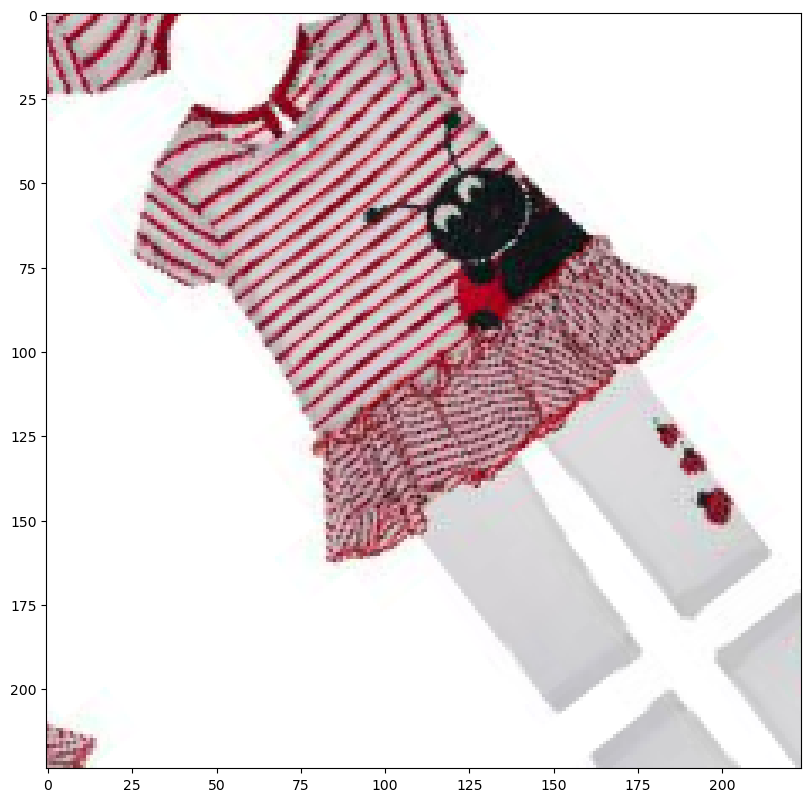

In [21]:
print('Number of Samples for each label')
for (k1, v1), (k2, v2) in zip(labels_quota['train'].items(), labels_quota['val'].items()):
    print(f'{k1}: train: {v1} - val: {v2}')
    
for image, label in train_ds.take(1):
    print(label)
    print(list(labels.keys())[np.argmax(label)])
    img = image.numpy() # convert EagerTensor to numpy

    """
    In order to plot the image in matplotlib.pyplot, we need 0 < image values < 1:
    1. we shift the values to values more than 0.
    2. We then normalize the values between [0, 1] # src: https://stackoverflow.com/a/1735122/6118987
    
    """
    if img.min() < 0:
        img += abs(img.min())

    img *= (1.0/img.max()) # src: https://stackoverflow.com/a/1735122/6118987

    print(img.min())
    print(img.max())
    plt.imshow(img)
    plt.show()

# print(image.numpy())

# Other approaches to image augmentations

### keras preprossing layers

https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

### tf.image

https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_3


In [22]:
# Number of train/validation images
print(train_ds.cardinality().numpy())
print(val_ds.cardinality().numpy())

4992
1247


In [23]:
"""
example

tf.data shuffle
tf.data.batch

"""
train_batches = train_ds.shuffle(100, reshuffle_each_iteration=False).batch(Params.batch_size)

for image, label in train_batches.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (16, 224, 224, 3)
Label:  [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Training and Transfer Learning Utils

In [24]:
"""
Classification metrics for tensorboard

Src:
    https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

"""

METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    
]


def create_model(optimizer, name='resnet', loss='categorical_crossentropy', blocks_to_train=[]):
    """
    Creates model based on the input name and freezes `blocks_to_train` blocks.
    Args: 
        optimizer(tf.keras.optimizers): initialized tensorflow optimizers.
        name(str): one of the keys in the `models` list.
        blocks_to_train: name of the blocks to freeze, if not given all the 
        layers will be trainable.
        loss: sets loss
        
    """
    base_model = models[name](include_top=False, weights='imagenet')
    # model = Model(base_model.inputs, base_model.layers[-1].output)

    if bool(blocks_to_train):
        for block in blocks_to_train:
            for layer in base_model.layers:
                if block in layer.name:
                    layer.trainable = True
                else:
                    layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = True
            
    x = GlobalAveragePooling2D()(base_model.layers[-1].output)
    x = Dense(1024, activation='relu')(x)
    output = Dense(12, activation='softmax')(x)

    model = Model(base_model.inputs, output)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=METRICS)
    return model


def scheduler(epoch):
    # Every 10 epochs, the learning rate is reduced to 1/10 of the original
    if epoch == 10:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.1)

    if epoch == 100:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.1)

    return K.get_value(model.optimizer.lr)

def generate_path(path_to_output, last_run=False):
    """
    Creates new path and returns the address.
    Notes:
        Sometimes accidently it happens that you overwrite your previous models. so
        this function is designed to create a new path for each run.
    """
    if not isdir(path_to_output):
        makedirs(path_to_output)
    
    runs = natsorted([path for path in listdir(path_to_output) if path.startswith("run_tf_data")])
    if last_run:
        if not bool(runs):
            path = join(path_to_output, "run_tf_data_1")
        else:
            path = join(path_to_output, runs[-1])

        return path
    if not bool(runs):
        path = join(path_to_output, 'run_tf_data_1')
    else:
        f = runs[-1].rsplit("data_")[1]
        path = join(path_to_output, 'run_tf_data_' + str(int(f) + 1))
    
    return path

# TensorBoard Utils

### Plotting confusion matrix on tensorboard

![image](https://github.com/tensorflow/tensorboard/blob/master/docs/images/images_cm.png?raw=1)

In [25]:
def plot_to_image(figure):
    """
    Saves plot as a png file.
    src: tensorflow.org docs
    https://stackoverflow.com/a/61443397/6118987
    https://www.tensorflow.org/tensorboard/image_summaries
    
    """
    # save plot to png file
    buf = BytesIO()
    plt.savefig(buf, format='png')

    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    # plt.close(figure)

    buf.seek(0)
    
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    buf.close()

    return image

def image_grid(data, labels, class_names):
    """
    Saves all images as a grid of class_names * class_names.
    src: tensorflow docs
    """
    assert data.ndim == 4
    figure = plt.figure(figsize=(10,10))
    
    num_images = data.shape[0]
    size = int(np.ceil(np.sqrt(num_images)))
    # class_names[int(tf.argmax(y[0]))
    for i in range(num_images):
        plt.subplot(size, size, i+1, title=class_names[int(tf.argmax(labels[i]))])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        # Grayscale images
        if data.shape[3] == 1:
            plt.imshow(data[i], cmap=plt.cm.binary)
        else:
            plt.imshow(data[i])

    return figure
    
def get_confusion_matrix(y_labels, logits, class_names):
    """
    Confusion matrix calculation.
    Src: Tensorflow docs
    """
    preds = np.argmax(logits, axis=1)
    labels = np.argmax(y_labels, axis=1).numpy()
    cm = confusion_matrix(
        labels,
        preds, 
        labels=np.arange(len(class_names))
    )

    return cm

def plot_confusion_matrix(cm, class_names):
    """
    Saves the confusion matrix as image.
    Src: Tensorflow docs
    """
    size=len(class_names)
    figure=plt.figure(figsize=(size, size))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    indices = np.arange(len(class_names))
    
    plt.xticks(indices, class_names, rotation=45)
    plt.yticks(indices, class_names)
    labels=np.around(
        cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    threshold = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.xlabel("True Label")
    plt.ylabel("Prediction label")
    cm_image = plot_to_image(figure)
    
    return  cm_image



### Set custom callback to write confusion matrix at the end of each validation step on validation data

Sources:
- https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12
- https://www.tensorflow.org/tensorboard/image_summaries

In [26]:
from datetime import datetime

main_path = generate_path(Params.path_to_save)
tb_logdir = f'{main_path}/acc_loss'
img_logdir = f'{main_path}/image/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_logdir)
cm_writer = tf.summary.create_file_writer(img_logdir+'/cm')

def log_confusion_matrix(epoch, logs):
    test_pred_raw = model.predict(np.array(val_ds_x))
    test_pred = np.argmax(test_pred_raw, axis=1)
    
    test_labels = np.argmax(val_ds_y, axis=1)
    
    # Calculate the confusion matrix
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    plt.close('all')
    # Log the confusion matrix as an image summary.
    with cm_writer.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [27]:
# !rm -r drive/MyDrive/logs/*

In [28]:
# Configure to performance
pattern = Params.data_path + '/*/*.jp*g'
train_ds, val_ds, num_samples = generator(pattern=pattern, validation_ratio=0.2, include_stats=True)

# Get train_size before split to batches and also using reeat function.
train_size = tf.data.experimental.cardinality(train_ds).numpy() 

"""
Note:
    If tf.data.Dataset.batch().repeat() => we have to define `steps_per_epoch` argument in `.fit` function.
    If tf.data.Dataset.batch() => you can use .fit() with no `steps_per_epoch` argument.
    
"""

train_ds = train_ds.batch(Params.batch_size).repeat()
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

### validation data can not be generators anymore according to:

- [source 1: tensorflow docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)
- [Source 2: stackoverflow comments ](https://stackoverflow.com/a/60003165/6118987)

> Validation data 

>  validation_data could be:
- tuple (x_val, y_val) of Numpy arrays or tensors.
- tuple (x_val, y_val, val_sample_weights) of Numpy arrays.

>  Note that validation_data does not support all the data types that are supported in x, eg, dict, generator or keras.utils.Sequence.

In [29]:
# Keras.fit does not accept generators anymore. 
# so let's keep the validation in separate list.

val_ds_x = []
val_ds_y = []

for _, (val_x, val_y) in enumerate(val_ds):
    val_ds_x.append(val_x)
    val_ds_y.append(val_y)

val_data = (tf.convert_to_tensor(val_ds_x, dtype=tf.float32), 
            tf.convert_to_tensor(val_ds_y, dtype=tf.float32))

In [30]:
val_data[0].numpy().shape

(1247, 224, 224, 3)

In [31]:
# Check for image and label shape.

item, label =  next(iter(train_ds))
print(item.shape)
print(label.shape)

(16, 224, 224, 3)
(16, 12)


# tf_explain Callbacks

We use tf-explain **GradCam callbacks** to visualize that how good the model can **extract the related features**.

![Pishi](https://tf-explain.readthedocs.io/en/latest/_images/grad_cam.png)

Source codes:
- https://medium.com/analytics-vidhya/tf-explain-working-283a311f1276
- https://tf-explain.readthedocs.io/en/latest/methods.html

In [32]:
# Set up the GradCam callback arguments
# Choosing 10 green labeled objects

validation_class_green = (
    np.array(
       [img for img, label in zip(val_ds_x, val_ds_y) if \
        np.all(np.argmax(label) == labels['green'])][0:10]),None
)

# Define tf-explain instance for GradCam Callbacks on one og classes (green)
tfe_callback = tfe.callbacks.GradCAMCallback(validation_class_green, 
                                             class_index=0,
                                             output_dir=join(main_path, 'image', 'grad_cam'),
                                             layer_name=Params.block_to_gradcam) # MobileNetV2 block_1_project

# Define Optimizer
optimizer = SGD(lr=Params.lr, 
                decay=Params.decay, 
                momentum=Params.momentum, 
                nesterov=Params.nesterov)

# define the model
model = create_model(optimizer, name=Params.model, blocks_to_train=[])

83689472/83683744 [==============================] - 1s 0us/step


In [33]:
# In order to use tensorboard magi
# %load_ext tensorboard
# Start TensorBoard.
# %tensorboard --logdir drive/MyDrive/logs/run_tf_data_1/ 

# Train the classifier.
print(f'train size: {sum(num_samples["train"].values())}')
print(f'val size: {val_ds.cardinality()}')
print("*"* 20)
print('Number of Samples for each label')
print("*" * 20)
for (k1, v1), (k2, v2) in zip(num_samples['train'].items(), num_samples['val'].items()):
    print(f'{k1}: train: {v1} - val: {v2}')
    
history = model.fit(train_ds,
                    epochs=Params.epochs,
                    callbacks=[tensorboard_callback, cm_callback,tfe_callback],
                    steps_per_epoch=train_size//Params.batch_size,
                    validation_data=val_data,
)


train size: 4992
val size: 1247
********************
Number of Samples for each label
********************
black: train: 264 - val: 71
blue: train: 511 - val: 141
brown: train: 546 - val: 139
green: train: 558 - val: 141
grey: train: 560 - val: 126
orange: train: 254 - val: 63
pink: train: 266 - val: 64
purple: train: 293 - val: 73
red: train: 551 - val: 138
silver: train: 281 - val: 66
white: train: 559 - val: 135
yellow: train: 349 - val: 90
Epoch 1/50
312/312 [==============================] - 89s 251ms/step - loss: 1.7565 - tp: 764.0639 - fp: 316.2077 - tn: 27315.2300 - fn: 1747.8850 - accuracy: 0.4197 - precision: 0.6307 - recall: 0.2314 - auc: 0.8185 - prc: 0.4305 - val_loss: 1.0885 - val_tp: 717.0000 - val_fp: 282.0000 - val_tn: 13435.0000 - val_fn: 530.0000 - val_accuracy: 0.6512 - val_precision: 0.7177 - val_recall: 0.5750 - val_auc: 0.9430 - val_prc: 0.7007
Epoch 2/50
312/312 [==============================] - 75s 240ms/step - loss: 0.9754 - tp: 1463.1118 - fp: 440.5527 - tn:

# Model Evaluation
In this part we check these items:
- **Plot loss for both train and validation.**
- **Plot precision, recall and area under the curve.**
- **Plot Confusion matrix based on True Positive/False Positive and True Negative/False Negative.**
- **Plot ROC curve and Area Under Precision-Recall Curve.**

# Plot Loss 

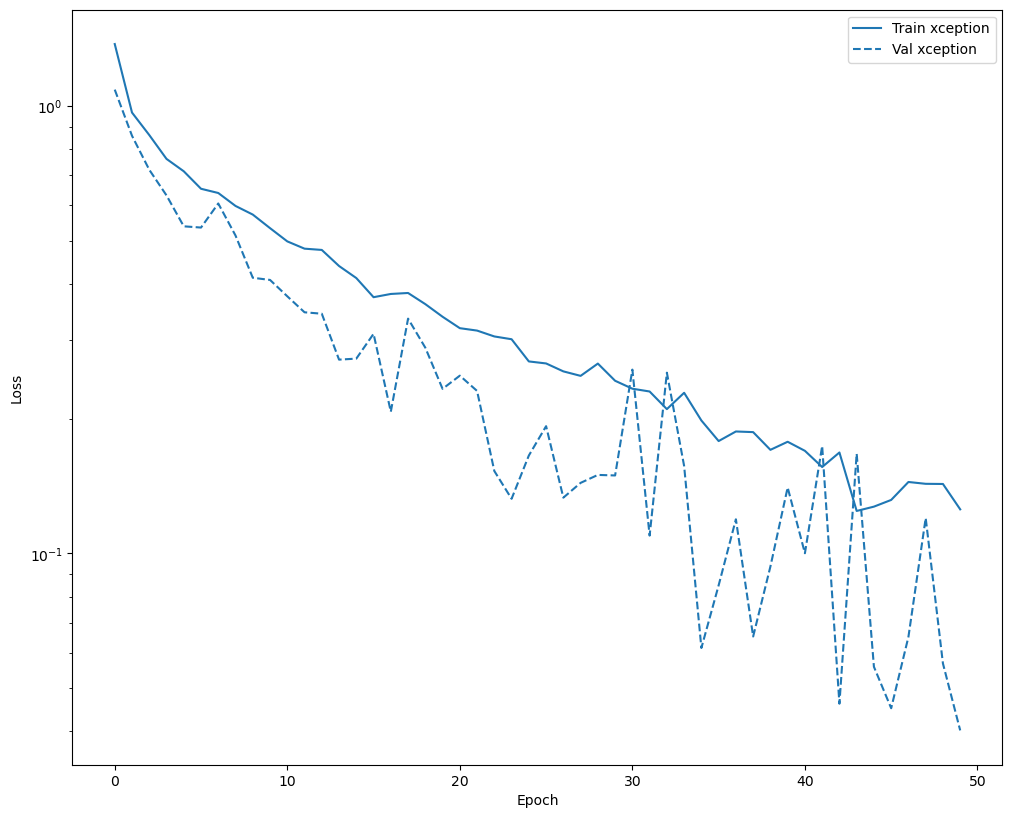

In [34]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics
# Plot loss

def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
plot_loss(history, Params.model, 0)

# Plot Loss/Precision/Recall/mean AUC

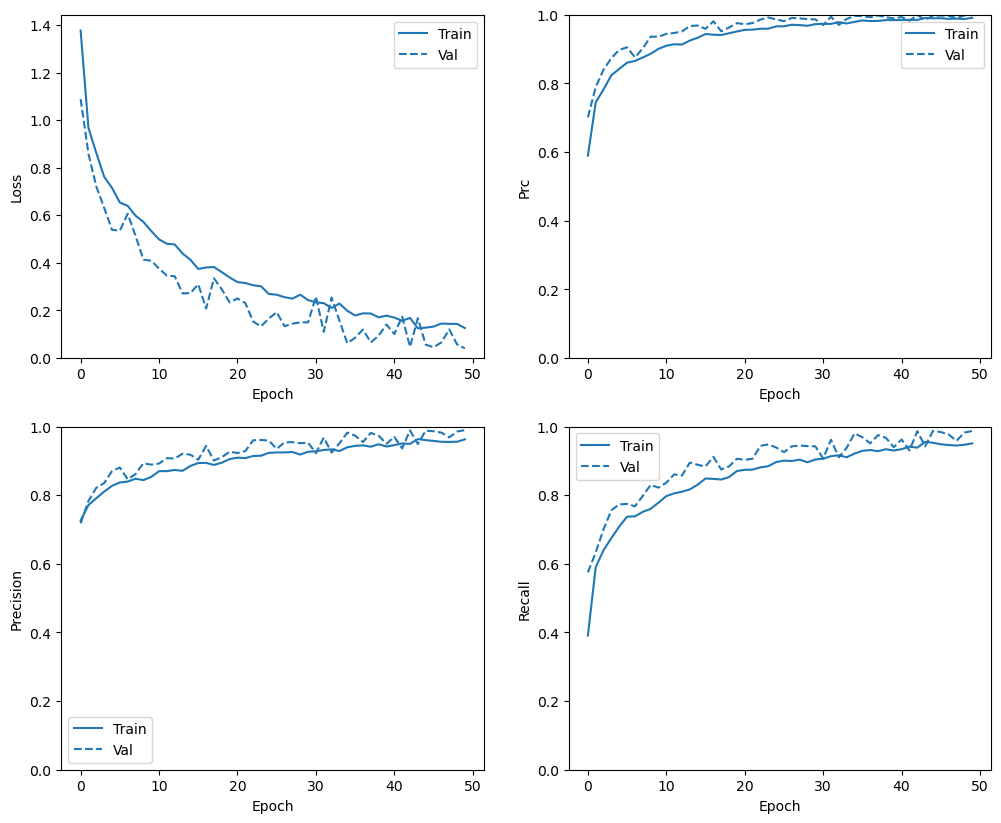

In [35]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], 
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

plot_metrics(history)

# Heatmap indicating Multi-Label Confusion Matrix

#### Src: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics

loss :  0.040222495794296265
tp :  1231.0
fp :  13.0
tn :  13704.0
fn :  16.0
accuracy :  0.9887730479240417
precision :  0.9895498156547546
recall :  0.9871692061424255
auc :  0.9999364614486694
prc :  0.9993093013763428



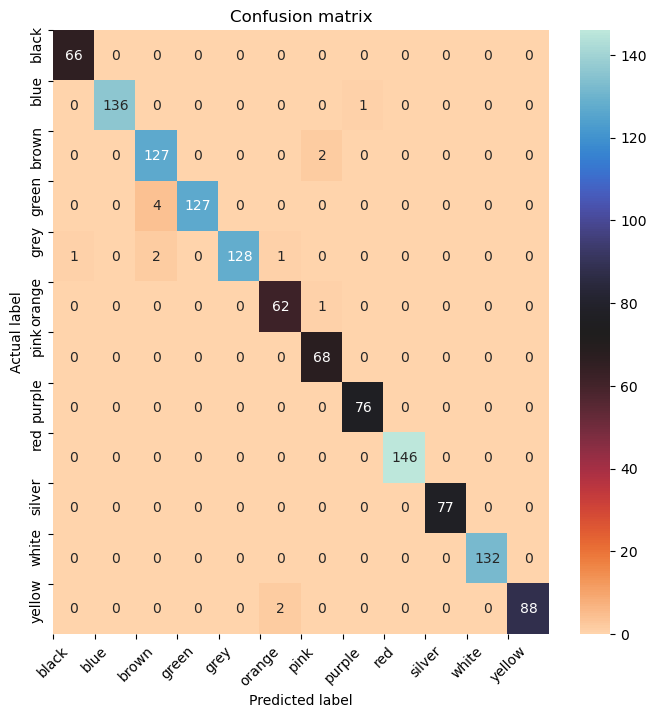

In [36]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics
# sns.color_palette("mako", as_cmap=True)
test_predictions_baseline = model.predict(val_data[0].numpy(), batch_size=Params.batch_size)

## CHECK
def plot_cm(label_matrix, predictions):
    
    preds = np.argmax(predictions, axis=1)
    labels_ = np.argmax(label_matrix, axis=1)
    
    cm = confusion_matrix(labels_, 
                          preds,
                          labels=np.arange(len(list(labels.keys()))))
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="icefire_r")
    indices = np.arange(len(class_names))
    plt.xticks(indices, class_names, rotation=45)
    plt.yticks(indices, class_names)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

baseline_results = model.evaluate(val_data[0].numpy(), 
                                  val_data[1].numpy(),
                                  batch_size=Params.batch_size, 
                                  verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(val_data[1].numpy(), test_predictions_baseline)


# Plot ROC

### Src:
### https://stackoverflow.com/a/45335434
### https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics

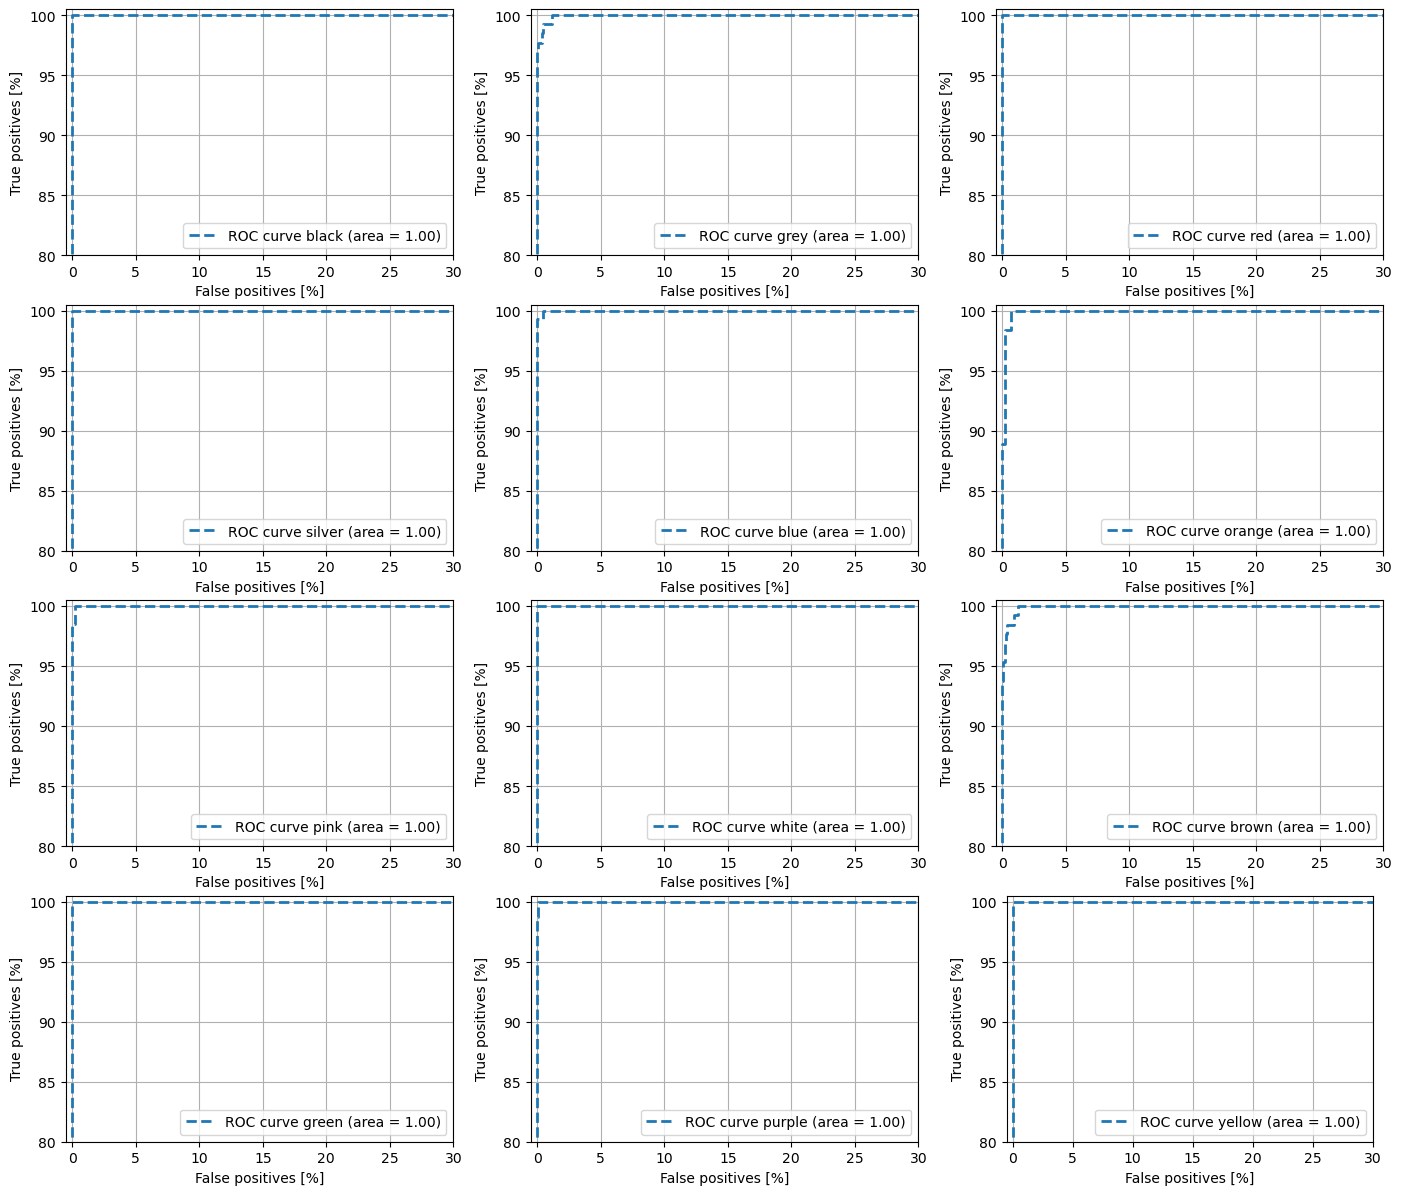

In [37]:
# https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_display_object_visualization.html#sphx-glr-auto-examples-miscellaneous-plot-display-object-visualization-py
# https://datascience.stackexchange.com/questions/77112/how-to-create-roc-auc-curves-for-multi-class-text-classification-problem-in-py
#         RocCurveDisplay

def plot_roc(name, labelsـ, predictions, **kwargs):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    temp = list(labels.keys())
    
    for i, item in enumerate(temp):
        fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(labelsـ[:, i], predictions[:, i])
        roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
    
    fig, axes = plt.subplots(4, 3, figsize=(17, 15))
    
    
    for i, item in enumerate(temp):
        ax = axes[i%4][i%3]
        ax.plot(100*fpr[i], 100*tpr[i], label=f'ROC curve {item} (area = {roc_auc[i]:.2f})', linewidth=2, **kwargs)
        ax.set_xlabel('False positives [%]')
        ax.set_ylabel('True positives [%]')
        ax.legend(loc="lower right")
#         ax.plot([0, 0], [100, 20], 'k--')
        ax.set_xlim([-0.5,30])
        ax.set_ylim([80,100.5])
        ax.grid(True)
        s = plt.gca()
        s.set_aspect('equal')

    
plot_roc("Test Baseline",
         val_data[1].numpy(), 
         test_predictions_baseline,
         color=colors[0], 
         linestyle='--')


# Plot Area Under the Curve

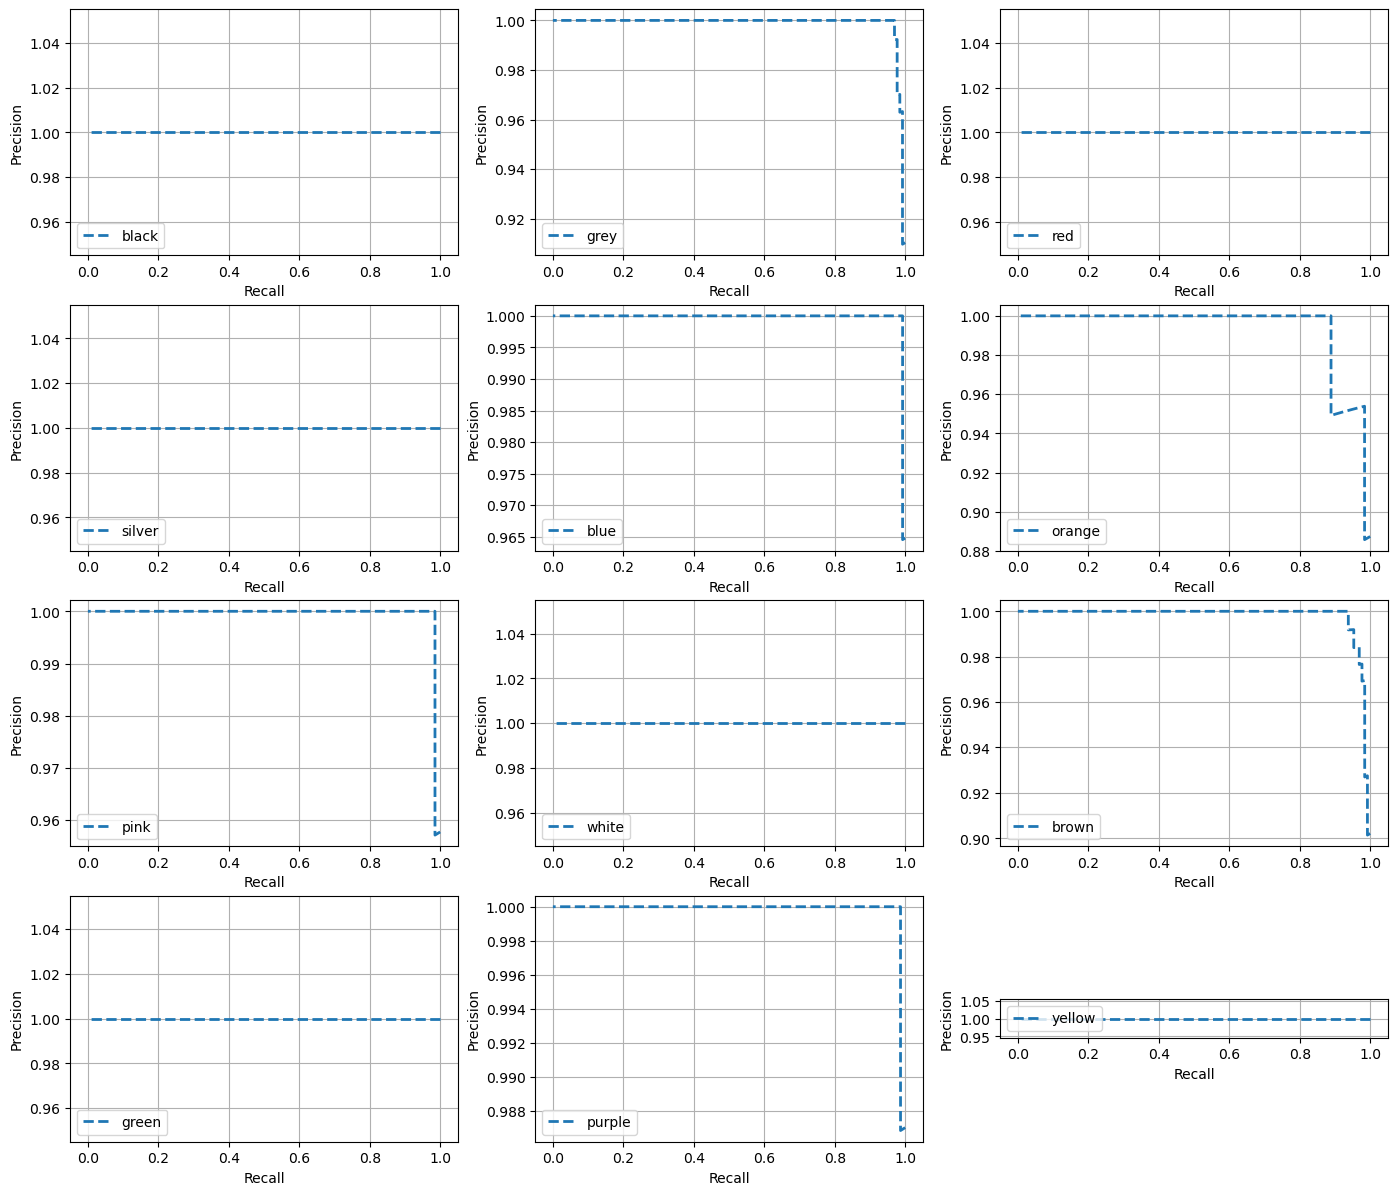

In [38]:
# Use this answer
# https://stackoverflow.com/a/45335434

def plot_prc(name, labels_, predictions, **kwargs):
    
    precision = dict()
    recall = dict()
    precision_recall_curve = dict()
    temp = list(labels.keys())
    fig, axes = plt.subplots(4, 3, figsize=(17, 15))
    
    for i, item in enumerate(temp):
        precision[i], recall[i], _ = sklearn.metrics.precision_recall_curve(labels_[:, i], predictions[:, i])
        ax = axes[i%4][i%3]
        ax.plot(recall[i], precision[i], lw=2, label=item, **kwargs)

        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower left')

        ax.grid(True)
        s = plt.gca()
        s.set_aspect('equal')

plot_prc("Test Baseline",
         val_data[1].numpy(),
         test_predictions_baseline,
         color=colors[0],
         linestyle='--')





# Tensorboard Confusion Matrix

### Epoch 110
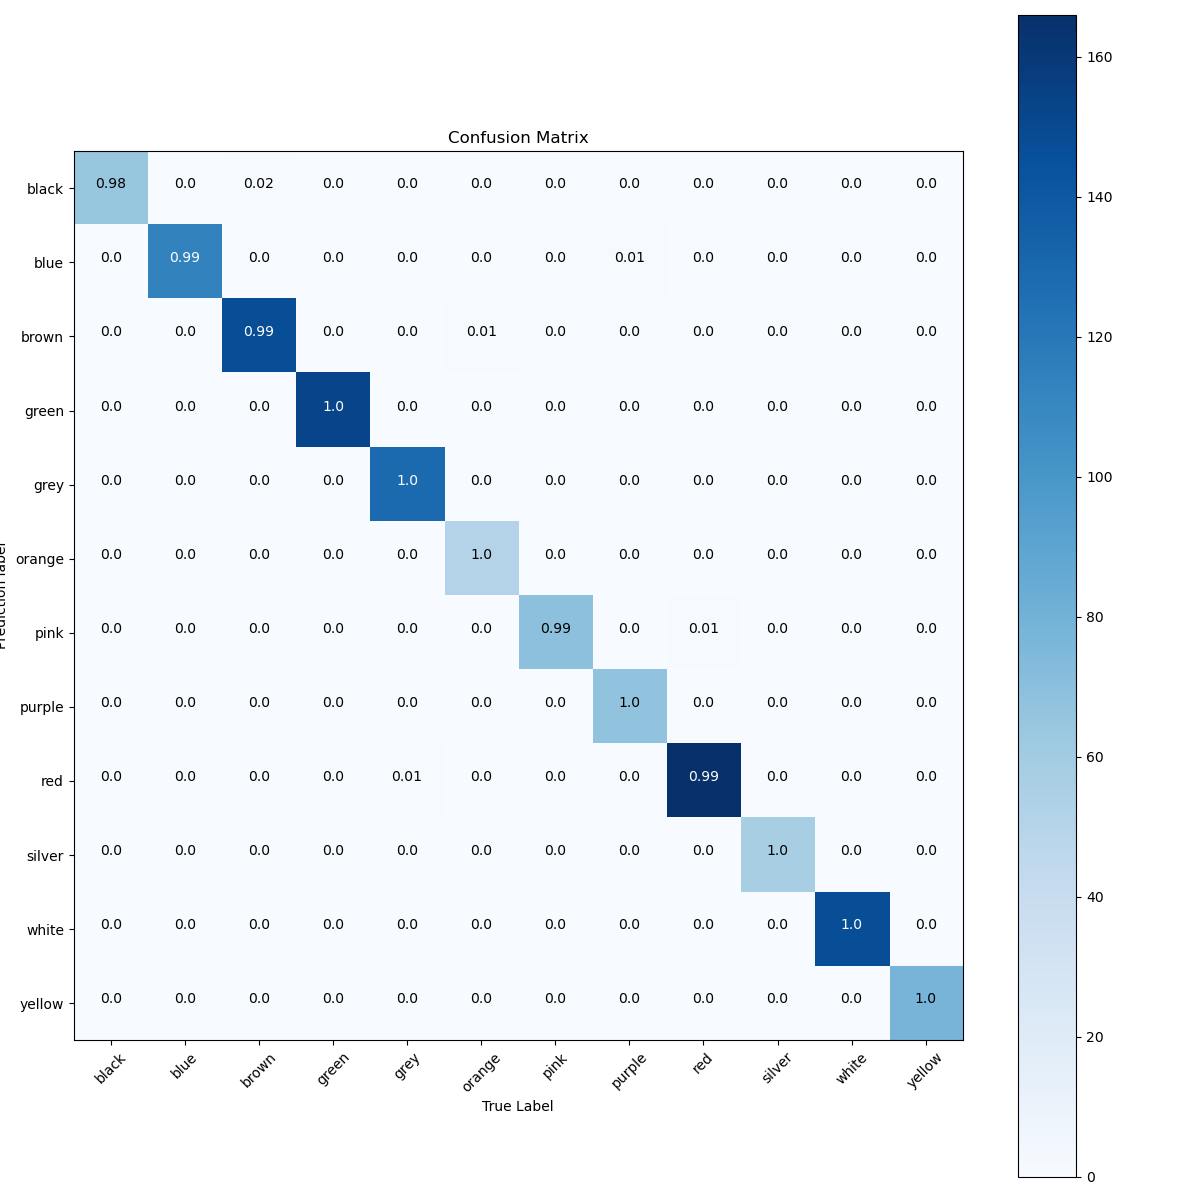

# GradCam Stripe Images

### Epoch 110
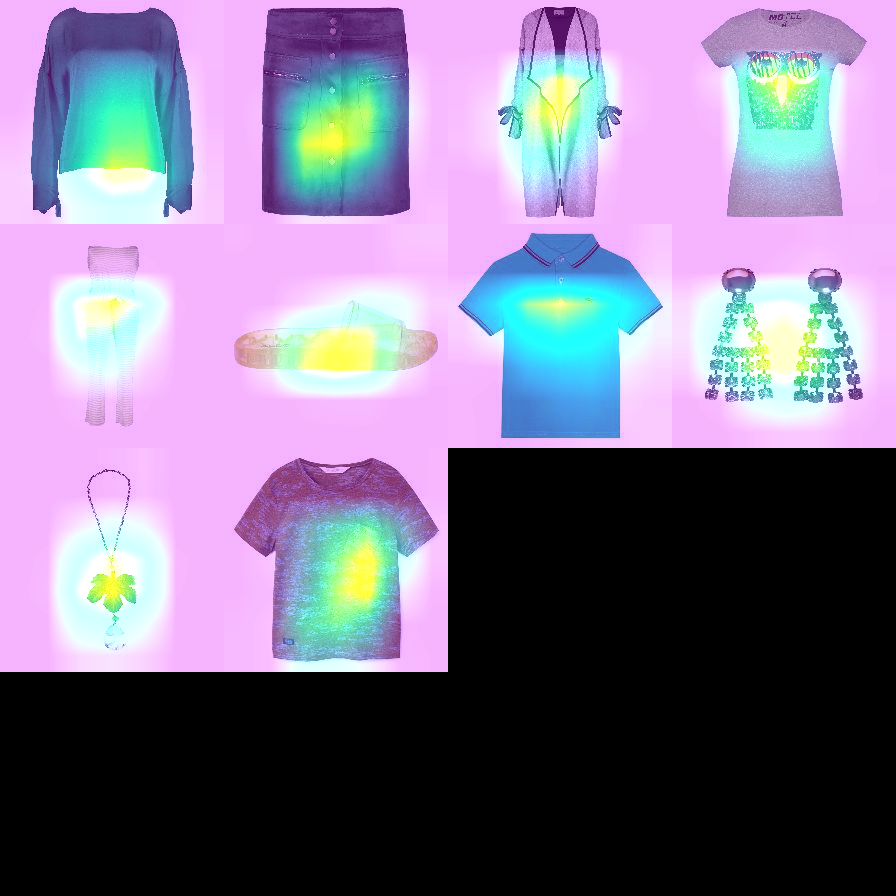


In [39]:
# !zip -r tfdata.zip ./drive/MyDrive/logs/
# !rm -r drive/MyDrive/logs/*